In [1]:
#|default_exp dataset

In [2]:
#| export
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
from datasets import  load_from_disk
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

In [3]:
from pdb import set_trace
import seaborn as sns
class CFG:
    CACHE_PATH = Path('../data/cache')

In [4]:
fns = list((CFG.CACHE_PATH/'batch_3').glob('*.pth'))

In [5]:
# | export
# function that loads the data from the pth file and return the data and the label as pd.DataFrame
def load_data(
    fn: Path,
    columns_event: str = ["time", "charge", "auxiliary", "x", "y", "z"],
    columns_label: str = ["azimuth", "zenith"],
    keep_auxiliary_event: bool = False,
):
    data = torch.load(fn)
    event = pd.DataFrame.from_records(data["event"])[columns_event]
    if keep_auxiliary_event:
        event = event.query("auxiliary == True")
    label = pd.DataFrame.from_records(data["target"])[columns_label]
    return event.astype(np.float32), label


class IceCubeCasheDatasetV0(Dataset):
    def __init__(self, fns, max_events=100):
        self.fns = fns
        self.max_events = max_events

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        fn = self.fns[idx]
        event, label = load_data(fn)

        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = torch.tensor(event.values)
        mask = torch.ones(len(event), dtype=torch.bool)
        label = torch.tensor(label.values, dtype=torch.float32)

        return {"event": event, "mask": mask, "label": label}


class IceCubeCasheDatasetV1(Dataset):
    """_summary_

    Args:
        Dataset (_type_): Same as IceCubeCasheDatasetV0 but with the option to keep the auxiliary events
    """

    def __init__(self, fns, max_events=100, keep_auxiliary_event: bool = True):
        self.fns = fns
        self.max_events = max_events
        self.keep_auxiliary_event = keep_auxiliary_event

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        fn = self.fns[idx]
        event, label = load_data(fn, keep_auxiliary_event=self.keep_auxiliary_event)

        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = torch.tensor(event.values)
        mask = torch.ones(len(event), dtype=torch.bool)
        label = torch.tensor(label.values, dtype=torch.float32)

        return {"event": event, "mask": mask, "label": label}


# collate_fn that pads the event and mask to the max length in the batch using pythorch pad_sequence
class HuggingFaceDatasetV0(Dataset):
    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = event.values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "event": torch.tensor(event),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


# function to normalize input between 1 and 0
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


class HuggingFaceDatasetV1(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        # feature engineering
        event["w1"] = event["charge"] * event["time"]
        event["w0"] = event["charge"] - event["w1"]

        event["wx0"] = event.x * event.w0
        event["wy0"] = event.y * event.w0
        event["wz0"] = event.z * event.w0
        event["wx1"] = event.x * event.w1
        event["wy1"] = event.y * event.w1
        event["wz1"] = event.z * event.w1

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "w1",
                "w0",
                "wx0",
                "wy0",
                "wz0",
                "wx1",
                "wy1",
                "wz1",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetV2(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetV3(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event["charge"] = np.log10(event["charge"])

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch

class HuggingFaceDatasetV4(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=160):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event["charge"] = np.log10(event["charge"])

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


def event_filtering_v1(batch, max_pulse_count=128, t_valid_length=6199.700247193777):
    col = batch.columns
    t_peak = batch["time"][batch["charge"].argmax()]
    t_valid_min = t_peak - t_valid_length
    t_valid_max = t_peak + t_valid_length
    t_valid = (batch["time"] > t_valid_min) * (batch["time"] < t_valid_max)
    batch["rank"] = 2 * (1 - batch["auxiliary"]) + (t_valid)
    batch = batch.sort_values(by=["rank", "charge"])
    # pick-up from backward
    batch = batch[-max_pulse_count:]
        # resort by time
    batch = batch.sort_values(by="time")
    return batch[col]
        

class HuggingFaceDatasetV5(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        event["time"] /= event["time"].max()
        
        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


In [6]:
#ds = IceCubeCasheDatasetV1(fns)
#dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn)
# for x in dl:
#     break

In [7]:
ds = HuggingFaceDatasetV5(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))

/opt/conda/lib/python3.7/site-packages/datasets/arrow_dataset.py:1536: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  FutureWarning,


In [22]:
#| export
def ice_transparency(
    data_path="/opt/slh/icecube/data/ice_transparency.txt", datum=1950
):
    # Data from page 31 of https://arxiv.org/pdf/1301.5361.pdf
    # Datum is from footnote 8 of page 29
    df = pd.read_csv(data_path, delim_whitespace=True)
    df["z"] = df["depth"] - datum
    df["z_norm"] = df["z"] / 500
    df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(
        df[["scattering_len", "absorption_len"]]
    )

    # These are both roughly equivalent after scaling
    f_scattering = interp1d(df["z_norm"], df["scattering_len_norm"])
    f_absorption = interp1d(df["z_norm"], df["absorption_len_norm"])
    return f_scattering, f_absorption

def prepare_sensors():
    sensors = pd.read_csv('/opt/slh/icecube/data/sensor_geometry.csv').astype(
        {
            "sensor_id": np.int16,
            "x": np.float32,
            "y": np.float32,
            "z": np.float32,
        }
    )
    sensors["string"] = 0
    sensors["qe"] = 1

    for i in range(len(sensors) // 60):
        start, end = i * 60, (i * 60) + 60
        sensors.loc[start:end, "string"] = i

        # High Quantum Efficiency in the lower 50 DOMs - https://arxiv.org/pdf/2209.03042.pdf (Figure 1)
        if i in range(78, 86):
            start_veto, end_veto = i * 60, (i * 60) + 10
            start_core, end_core = end_veto + 1, (i * 60) + 60
            sensors.loc[start_core:end_core, "qe"] = 1.35

    # https://github.com/graphnet-team/graphnet/blob/b2bad25528652587ab0cdb7cf2335ee254cfa2db/src/graphnet/models/detector/icecube.py#L33-L41
    # Assume that "rde" (relative dom efficiency) is equivalent to QE
    sensors["x"] /= 500
    sensors["y"] /= 500
    sensors["z"] /= 500
    sensors["qe"] -= 1.25
    sensors["qe"] /= 0.25

    return sensors.set_index("sensor_id")[['qe']]


def convert_to_3d(azimuth, zenith):
    """Converts zenith and azimuth to 3D direction vectors"""
    x = np.cos(azimuth) * np.sin(zenith)
    y = np.sin(azimuth) * np.sin(zenith)
    z = np.cos(zenith)
    return np.array([x, y, z], dtype=np.float32)


class HuggingFaceDatasetV6(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetV7(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch



class HuggingFaceDatasetV8(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=148):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch
    



class HuggingFaceDatasetV9(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


In [23]:
ds = HuggingFaceDatasetV9(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))
ds[0]['event'].shape

/opt/conda/lib/python3.7/site-packages/datasets/arrow_dataset.py:1536: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  FutureWarning,


torch.Size([61, 9])

In [22]:
time = ds[0]['event'][0]
x = ds[0]['event'][3]
y = ds[0]['event'][4]
z = ds[0]['event'][5]
chage = ds[0]['event'][1]
magnitude = torch.sqrt(x ** 2 + y ** 2 + z ** 2)
distance = magnitude / 3 * 10 ** 8
time_of_flight = time + distance

In [12]:
ds[0]['event'].shape

torch.Size([61, 9])

In [13]:
from torch_geometric.data import Data

/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
# | export


# pytorch function that takes [n, x, y, z] tensor and calculates the distance between each point and returns [n x n] matrix using torch.cdist
def get_distance_matrix(xyz):
    return torch.cdist(xyz, xyz)


def get_distance_matrix_for_indices(dm, indices):
    return dm[indices][:, indices]


def get_distance_matrix_from_csv(
    path_to_geom="/opt/slh/icecube/data/sensor_geometry.csv",
):
    geom = pd.read_csv(path_to_geom)[["x", "y", "z"]]
    geom = torch.tensor(geom.values, dtype=torch.float32)
    geom = get_distance_matrix(geom)
    # nromalize goematry matrix
    geom = geom / geom.max()
    return geom


class HuggingFaceDatasetGraphV0(Dataset):
    def __init__(self, ds, min_adj_distance=0.015, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])
        self.mad = min_adj_distance
        self.distance_matrix_ = get_distance_matrix_from_csv()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        event["charge"] = np.log10(event["charge"])

        # getting distance matrix for event
        distance_matrix = get_distance_matrix_for_indices(
            self.distance_matrix_, event["sensor_id"].values
        )

        dmx = torch.zeros((self.max_events, self.max_events), dtype=torch.float32)
        dmx[: distance_matrix.shape[0], : distance_matrix.shape[1]] = distance_matrix
        adjecent_matrix = (dmx < self.mad).type(torch.float32)

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "distance_matrix": dmx,
                "adjecent_matrix": adjecent_matrix,
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetGraphV1(Dataset):
    def __init__(self, ds, min_adj_distance=0.05, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.mad = min_adj_distance
        self.distance_matrix_ = get_distance_matrix_from_csv()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        if self.max_events:
            event = event[: self.max_events]
        # in this way the time start at 0 and end at 1
        event["time"] = (event['time'] - 1.0e04) / 3.0e4

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event['x'] /=500
        event['y'] /=500
        event['z'] /=500

        event["charge"] = np.log10(event["charge"])/3.0

        # getting distance matrix for event
        distance_matrix = get_distance_matrix_for_indices(
            self.distance_matrix_, event["sensor_id"].values
        )

        dmx = torch.zeros((self.max_events, self.max_events), dtype=torch.float32)
        dmx[: distance_matrix.shape[0], : distance_matrix.shape[1]] = distance_matrix
        adjecent_matrix = (dmx < self.mad).type(torch.float32)

        event = event[
            [

                "charge",
                "auxiliary",
                "time",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "distance_matrix": dmx,
                "adjecent_matrix": adjecent_matrix,
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch




/opt/conda/lib/python3.7/site-packages/datasets/arrow_dataset.py:1536: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  FutureWarning,


<AxesSubplot:>

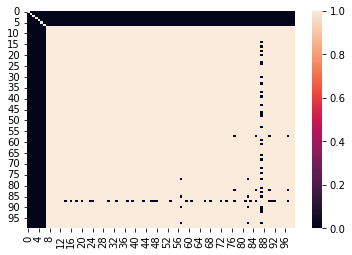

In [11]:
ds = HuggingFaceDatasetGraphV1(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))
sns.heatmap(ds[np.random.randint(0, len(ds))]['adjecent_matrix'].numpy())
#dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn_graphv0)
#for x in dl:
#     break

In [12]:
#| export
def good_luck():
    return True

In [13]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()

In [14]:
# class IceCubeKaggle():
#     """`Detector` class for Kaggle Competition."""

#     # Implementing abstract class attribute

#     def _forward(self, data: Data) -> Data:
#         """Ingest data, build graph, and preprocess features.
#         Args:
#             data: Input graph data.
#         Returns:
#             Connected and preprocessed graph data.
#         """
#         # Check(s)
#         self._validate_features(data)

#         # Preprocessing
#         data.x[:, 0] /= 500.0  # x
#         data.x[:, 1] /= 500.0  # y
#         data.x[:, 2] /= 500.0  # z
#         data.x[:, 3] = (data.x[:, 3] - 1.0e04) / 3.0e4  # time
#         data.x[:, 4] = torch.log10(data.x[:, 4]) / 3.0  # charge

#         return data

# class Direction(Label):
#     """Class for producing particle direction/pointing label."""

#     def __init__(
#         self, azimuth_key: str = "azimuth", zenith_key: str = "zenith"
#     ):
#         """Construct `Direction`."""
#         self._azimuth_key = azimuth_key
#         self._zenith_key = zenith_key

#     def __call__(self, graph: Data) -> torch.tensor:
#         """Compute label for `graph`."""
#         x = torch.cos(graph[self._azimuth_key]) * torch.sin(
#             graph[self._zenith_key]
#         ).reshape(-1, 1)
#         y = torch.sin(graph[self._azimuth_key]) * torch.sin(
#             graph[self._zenith_key]
#         ).reshape(-1, 1)
#         z = torch.cos(graph[self._zenith_key]).reshape(-1, 1)
#         return torch.cat((x, y, z), dim=1)

In [15]:
m = get_distance_matrix_from_csv()[:50,:50]

In [16]:
def create_adjacent_matrix_from_distance_matrix(distance_matrix):
    n = distance_matrix.shape[0]
    adjacency_matrix = torch.zeros((n, n), dtype=torch.bool)
    
    for i in range(n):
        nearest_neighbors = torch.argsort(distance_matrix[i])[1:9]
        adjacency_matrix[i, nearest_neighbors] = 1
        
    return adjacency_matrix

<AxesSubplot:>

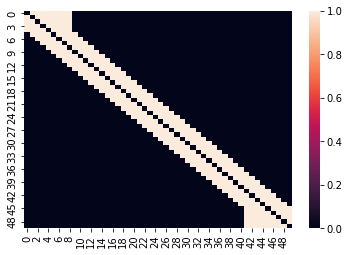

In [17]:
sns.heatmap(create_adjacent_matrix_from_distance_matrix(m))

In [18]:
xyzt = ds[0]['event'][:, 2:]

<AxesSubplot:>

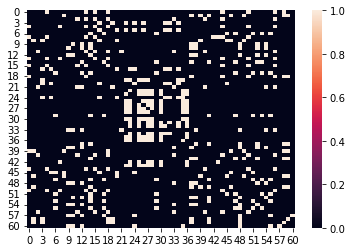

In [19]:
sns.heatmap(create_adjacent_matrix_from_distance_matrix(torch.cdist(xyzt, xyzt)))

In [39]:
class HuggingFaceDatasetX(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "x",
                "y",
                "z",
                "time",
                "charge",
                "auxiliary",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch
    
    
from torch_geometric.data import Data
from torch_geometric.data import Dataset as gDataset
from torch_geometric.loader import DataLoader as gDataLoader
from graphnet.models.graph_builders import KNNGraphBuilder

pre_transform = KNNGraphBuilder(nb_nearest_neighbours=8)

class IceCubeSubmissionDataset(gDataset):
    def __init__(
        self,
        ds,
        pulse_limit=300,
        transform=None,
        pre_transform=pre_transform,
        pre_filter=None,
    ):
        super().__init__(transform, pre_transform, pre_filter)
        self.ds = ds

    def len(self):
        return len(self.ds)

    def get(self, idx):
        batch = self.ds[0]
        data = Data(x=batch['event'], 
                    pos= batch['event'][:, :3],
                    n_pulses=torch.tensor(batch['event'].shape[0],
                                          dtype=torch.int32))
        return data


In [64]:
ds = IceCubeSubmissionDataset(ds=HuggingFaceDatasetX(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet')), 
                          )

/opt/conda/lib/python3.7/site-packages/datasets/arrow_dataset.py:1536: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  FutureWarning,


In [65]:
gdl = gDataLoader(ds, batch_size=10, shuffle=False, num_workers=1)
batch = next(iter(gdl))

In [112]:
from typing import Callable, Optional, Union
import torch
from torch.nn import functional as F
import torch_geometric
from torch_geometric.nn import  global_add_pool, global_mean_pool
import torch_scatter
from torch_scatter import scatter

import torch
from torch.nn import Linear, ReLU, SiLU, Sequential
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool
from torch_scatter import scatter


class EGNNLayer(MessagePassing):
    def __init__(self, emb_dim, activation="relu", norm="layer", aggr="add"):
        """E(n) Equivariant GNN Layer
        Paper: E(n) Equivariant Graph Neural Networks, Satorras et al.
        
        Args:
            emb_dim: (int) - hidden dimension `d`
            activation: (str) - non-linearity within MLPs (swish/relu)
            norm: (str) - normalisation layer (layer/batch)
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.activation = {"swish": SiLU(), "relu": ReLU()}[activation]
        self.norm = {"layer": torch.nn.LayerNorm, "batch": torch.nn.BatchNorm1d}[norm]

        # MLP `\psi_h` for computing messages `m_ij`
        self.mlp_msg = Sequential(
            Linear(2 * emb_dim + 1, emb_dim),
            self.norm(emb_dim),
            self.activation,
            Linear(emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
        )
        # MLP `\psi_x` for computing messages `\overrightarrow{m}_ij`
        self.mlp_pos = Sequential(
            Linear(emb_dim, emb_dim), self.norm(emb_dim), self.activation, Linear(emb_dim, 1)
        )
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        self.mlp_upd = Sequential(
            Linear(2 * emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
            Linear(emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
        )

    def forward(self, h, pos, edge_index):
        """
        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
        Returns:
            out: [(n, d),(n,3)] - updated node features
        """
        out = self.propagate(edge_index, h=h, pos=pos)
        return out

    def message(self, h_i, h_j, pos_i, pos_j):
        # Compute messages
        pos_diff = pos_i - pos_j
        dists = torch.norm(pos_diff, dim=-1).unsqueeze(1)
        msg = torch.cat([h_i, h_j, dists], dim=-1)
        msg = self.mlp_msg(msg)
        # Scale magnitude of displacement vector
        pos_diff = pos_diff * self.mlp_pos(msg)  # torch.clamp(updates, min=-100, max=100)
        return msg, pos_diff

    def aggregate(self, inputs, index):
        msgs, pos_diffs = inputs
        # Aggregate messages
        msg_aggr = scatter(msgs, index, dim=self.node_dim, reduce=self.aggr)
        # Aggregate displacement vectors
        pos_aggr = scatter(pos_diffs, index, dim=self.node_dim, reduce="mean")
        return msg_aggr, pos_aggr

    def update(self, aggr_out, h, pos):
        msg_aggr, pos_aggr = aggr_out
        upd_out = self.mlp_upd(torch.cat([h, msg_aggr], dim=-1))
        upd_pos = pos + pos_aggr
        return upd_out, upd_pos

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})"


class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim, activation="relu", norm="layer", aggr="add"):
        """Vanilla Message Passing GNN layer
        
        Args:
            emb_dim: (int) - hidden dimension `d`
            activation: (str) - non-linearity within MLPs (swish/relu)
            norm: (str) - normalisation layer (layer/batch)
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.activation = {"swish": SiLU(), "relu": ReLU()}[activation]
        self.norm = {"layer": torch.nn.LayerNorm, "batch": torch.nn.BatchNorm1d}[norm]

        # MLP `\psi_h` for computing messages `m_ij`
        self.mlp_msg = Sequential(
            Linear(2 * emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
            Linear(emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
        )
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        self.mlp_upd = Sequential(
            Linear(2 * emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
            Linear(emb_dim, emb_dim),
            self.norm(emb_dim),
            self.activation,
        )

    def forward(self, h, edge_index):
        """
        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h)
        return out

    def message(self, h_i, h_j):
        # Compute messages
        msg = torch.cat([h_i, h_j], dim=-1)
        msg = self.mlp_msg(msg)
        return msg

    def aggregate(self, inputs, index):
        # Aggregate messages
        msg_aggr = scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
        return msg_aggr

    def update(self, aggr_out, h):
        upd_out = self.mlp_upd(torch.cat([h, aggr_out], dim=-1))
        return upd_out

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})"
    
class EGNNModel(torch.nn.Module):
    def __init__(
        self,
        num_layers=5,
        emb_dim=128,
        in_dim=9,
        out_dim=3,
        activation="relu",
        norm="layer",
        aggr="sum",
        pool="sum",
        residual=True
    ):
        """E(n) Equivariant GNN model 
        
        Args:
            num_layers: (int) - number of message passing layers
            emb_dim: (int) - hidden dimension
            in_dim: (int) - initial node feature dimension
            out_dim: (int) - output number of classes
            activation: (str) - non-linearity within MLPs (swish/relu)
            norm: (str) - normalisation layer (layer/batch)
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
            pool: (str) - global pooling function (sum/mean)
            residual: (bool) - whether to use residual connections
        """
        super().__init__()

        # Embedding lookup for initial node features
        self.emb_in = torch.nn.Linear(in_dim, emb_dim)

        # Stack of GNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(EGNNLayer(emb_dim, activation, norm, aggr))

        # Global pooling/readout function
        self.pool = {"mean": global_mean_pool, "sum": global_add_pool}[pool]

        # Predictor MLP
        self.pred = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, emb_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(emb_dim, out_dim)
        )
        self.residual = residual

    def forward(self, batch):
        
        h = self.emb_in(batch.x)  # (n,) -> (n, d)
        pos = batch.pos  # (n, 3)

        for conv in self.convs:
            # Message passing layer
            h_update, pos_update = conv(h, pos, batch.edge_index)

            # Update node features (n, d) -> (n, d)
            h = h + h_update if self.residual else h_update 

            # Update node coordinates (no residual) (n, 3) -> (n, 3)
            pos = pos_update

        out = self.pool(h, batch.batch)  # (n, d) -> (batch_size, d)
        return self.pred(out)  # (batch_size, out_dim)

In [113]:
from graphnet.models.utils import calculate_xyzt_homophily

In [74]:
EGNNModel()

EGNNModel(
  (emb_in): Linear(in_features=9, out_features=128, bias=True)
  (convs): ModuleList(
    (0): EGNNLayer(emb_dim=128, aggr=sum)
    (1): EGNNLayer(emb_dim=128, aggr=sum)
    (2): EGNNLayer(emb_dim=128, aggr=sum)
    (3): EGNNLayer(emb_dim=128, aggr=sum)
    (4): EGNNLayer(emb_dim=128, aggr=sum)
  )
  (pred): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [48]:
from torch_scatter import scatter_max, scatter_mean, scatter_min, scatter_sum

In [69]:
global_means = scatter_mean(batch.x, batch.batch, dim=0)

In [71]:
global_means.shape

torch.Size([10, 9])

In [73]:
calculate_xyzt_homophily(batch.x, batch.edge_index, batch.batch)

(tensor([[0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520]]),
 tensor([[0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520],
         [0.2520]]),
 tensor([[0.0656],
         [0.0656],
         [0.0656],
         [0.0656],
         [0.0656],
         [0.0656],
         [0.0656],
         [0.0656],
         [0.0656],
         [0.0656]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]))

In [109]:
net = EGNN_Network(
    num_tokens = 8,
    num_positions = 1024,           # unless what you are passing in is an unordered set, set this to the maximum sequence length
    dim = 32,
    depth = 3,
    num_nearest_neighbors = 8,
    coor_weights_clamp_value = 2.,  
    update_coors = False,
)

feats = torch.randn(1, 128, 8) # (1, 1024)
coors = torch.randn(1, 128, 3)         # (1, 1024, 3)
mask = torch.ones_like(torch.rand(1, 128)).bool()    # (1, 1024)

out = net(feats, coors, mask = mask) # (1, 1024, 32), (1, 1024, 3)

In [106]:
out

tensor([[[-0.6222, -0.6894,  1.4351,  ...,  0.6770, -0.1985, -0.3066],
         [ 0.1334,  0.5690,  1.1985,  ...,  0.5571,  1.1911,  0.2584],
         [-0.7382, -2.4675, -2.0786,  ...,  0.1279, -0.0603,  0.6245],
         ...,
         [-1.5872, -1.0584, -2.1567,  ..., -1.0447,  0.5525, -0.3704],
         [-1.5893, -0.8412, -1.3699,  ...,  0.2627, -1.1399, -1.2501],
         [ 1.4129, -0.6143,  0.7806,  ...,  0.3414,  2.3914,  0.5984]]],
       grad_fn=<CatBackward0>)

In [98]:
net

EGNN_Network(
  (token_emb): Linear(in_features=8, out_features=32, bias=True)
  (pos_emb): Embedding(1024, 32)
  (layers): ModuleList(
    (0): ModuleList(
      (0): None
      (1): EGNN(
        (edge_mlp): Sequential(
          (0): Linear(in_features=65, out_features=130, bias=True)
          (1): Identity()
          (2): SiLU()
          (3): Linear(in_features=130, out_features=16, bias=True)
          (4): SiLU()
        )
        (node_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (coors_norm): Identity()
        (node_mlp): Sequential(
          (0): Linear(in_features=48, out_features=64, bias=True)
          (1): Identity()
          (2): SiLU()
          (3): Linear(in_features=64, out_features=32, bias=True)
        )
        (coors_mlp): Sequential(
          (0): Linear(in_features=16, out_features=64, bias=True)
          (1): Identity()
          (2): SiLU()
          (3): Linear(in_features=64, out_features=1, bias=True)
        )
      )
    )